In [107]:
pip install pyspark pandas matplotlib seaborn plotly geopandas calmap numpy scipy


Note: you may need to restart the kernel to use updated packages.


In [119]:
# PySpark and visualization imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import calmap

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Groundwater Depletion Analysis") \
    .getOrCreate()


In [125]:
# Load the dataset
df = spark.read.csv(r"file:///C:/Users/sujit/OneDrive/Desktop/BDA/BDA projext 2.0/groundwater_data_processed.csv",
                    header=True, inferSchema=True)

# Show schema and first rows
df.printSchema()
df.show(5)


root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Groundwater_Level_Index: double (nullable = true)
 |-- Water_Stress_Percent: double (nullable = true)
 |-- Population_Millions: double (nullable = true)
 |-- Annual_Withdrawal_km3: double (nullable = true)
 |-- Annual_Rainfall_mm: double (nullable = true)
 |-- Depletion_Rate_m_per_year: double (nullable = true)

+-------+----------+----+-----------------------+--------------------+-------------------+---------------------+------------------+-------------------------+
|Country|    Region|Year|Groundwater_Level_Index|Water_Stress_Percent|Population_Millions|Annual_Withdrawal_km3|Annual_Rainfall_mm|Depletion_Rate_m_per_year|
+-------+----------+----+-----------------------+--------------------+-------------------+---------------------+------------------+-------------------------+
|  India|South Asia|1990|                 100.75|               71.72|             1200.

In [129]:
# Drop rows with nulls in important columns
df = df.dropna(subset=["Country", "Region", "Water_Stress_Percent", "Depletion_Rate_m_per_year"])

# Parse date if available
if 'Date' in df.columns:  # if your CSV has a date column
    df = df.withColumn('sample_ts', to_date(col('Date'), 'yyyy-MM-dd'))
    df = df.withColumn('year', year(col('sample_ts')))
    df = df.withColumn('month', month(col('sample_ts')))
else:
    df = df.withColumn('year', col('Year'))  # Use Year column


In [133]:
from pyspark.sql.functions import col

# Top 10 countries by water stress
top10_stress = df.orderBy(col("Water_Stress_Percent").desc()).limit(10)

# Top 10 countries by depletion rate
top10_depletion = df.orderBy(col("Depletion_Rate_m_per_year").desc()).limit(10)

# Convert to Pandas for visualization
top10_stress_pd = top10_stress.toPandas()
top10_depletion_pd = top10_depletion.toPandas()

# Display
top10_stress_pd
top10_depletion_pd


,Country,Region,year,Groundwater_Level_Index,Water_Stress_Percent,Population_Millions,Annual_Withdrawal_km3,Annual_Rainfall_mm,Depletion_Rate_m_per_year
0,Japan,East Asia,1990,99.72,34.74,100.00,10.000,806.6,-0.2
1,Japan,East Asia,1999,99.45,35.51,114.34,12.977,856.1,-0.2
2,Japan,East Asia,1991,99.58,37.43,101.50,10.302,1131.6,-0.2
3,Japan,East Asia,1992,98.76,33.26,103.02,10.611,786.8,-0.2
4,Japan,East Asia,1993,103.27,34.89,104.57,10.927,1045.9,-0.2
5,Japan,East Asia,1994,101.72,35.89,106.14,11.250,885.3,-0.2
6,Japan,East Asia,1995,101.44,36.74,107.73,11.581,769.5,-0.2
7,Japan,East Asia,1996,97.93,35.97,109.34,11.919,702.6,-0.2
8,Japan,East Asia,1997,96.76,38.57,110.98,12.264,684.5,-0.2
9,Japan,East Asia,1998,98.75,35.89,112.65,12.617,849.6,-0.2


In [135]:
# Convert Spark DataFrames to Pandas
top10_stress_pd = top10_stress.toPandas()
top10_depletion_pd = top10_depletion.toPandas()
df_pd = df.toPandas()


C:\Users\sujit\AppData\Local\Temp\ipykernel_12028\374119473.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_stress_pd, x='Country', y='Water_Stress_Percent', palette='Reds_r')


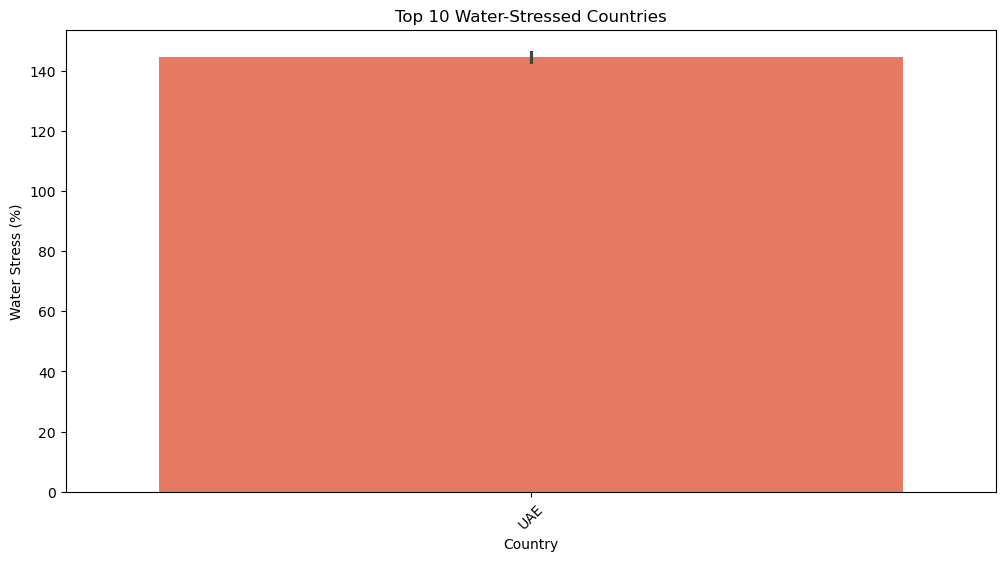

Observation: These countries exhibit the highest water stress levels globally.


In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=top10_stress_pd, x='Country', y='Water_Stress_Percent', palette='Reds_r')
plt.title("Top 10 Water-Stressed Countries")
plt.xlabel("Country")
plt.ylabel("Water Stress (%)")
plt.xticks(rotation=45)
plt.show()

# Print insight
print("Observation: These countries exhibit the highest water stress levels globally.")


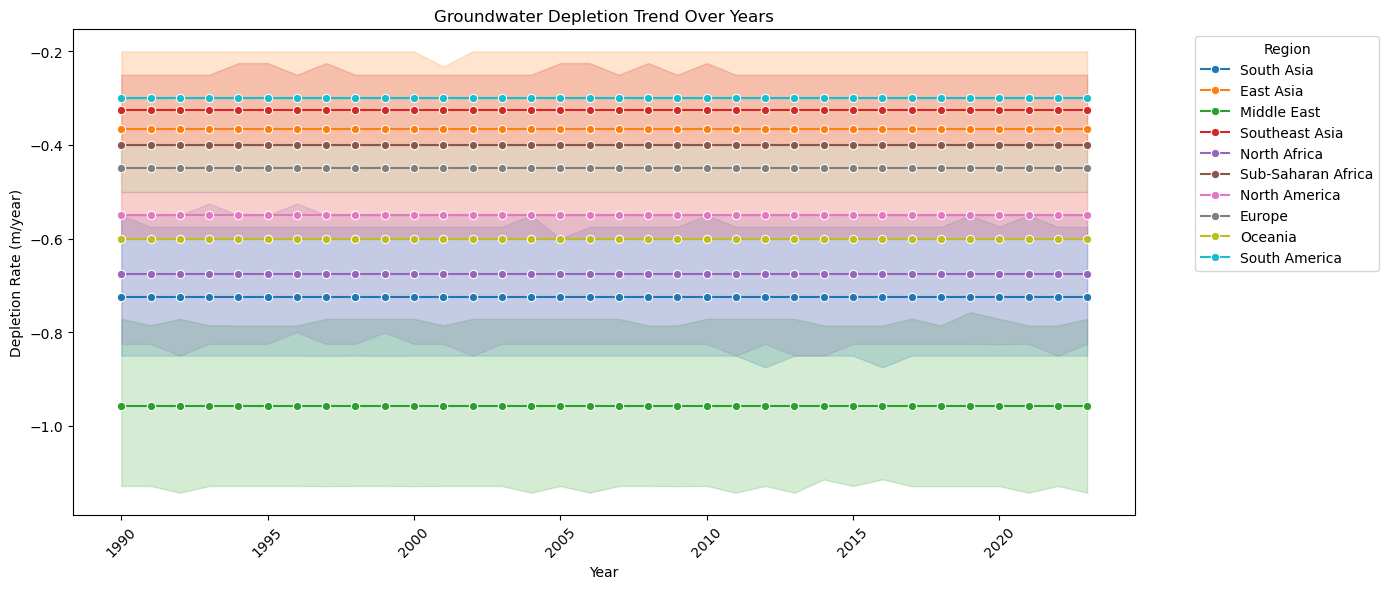

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(
    data=df_pd, 
    x='year', 
    y='Depletion_Rate_m_per_year', 
    hue='Region', 
    marker="o"
)

plt.title("Groundwater Depletion Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Depletion Rate (m/year)")
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


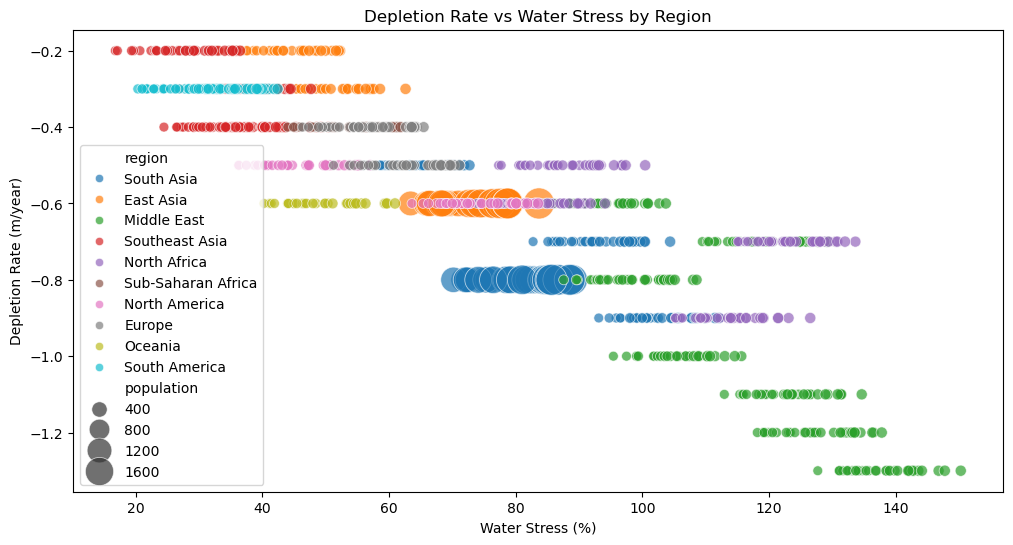

In [163]:
scatter_df = df.select(
    col("Country").alias("country"),
    col("Region").alias("region"),
    col("Water_Stress_Percent").alias("water_stress_percent"),
    col("Depletion_Rate_m_per_year").alias("depletion_rate"),
    col("Population_Millions").alias("population")
)

scatter_pd = scatter_df.toPandas()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=scatter_pd,
    x='water_stress_percent',
    y='depletion_rate',
    hue='region',
    size='population',
    sizes=(50, 500),
    alpha=0.7
)
plt.title("Depletion Rate vs Water Stress by Region")
plt.xlabel("Water Stress (%)")
plt.ylabel("Depletion Rate (m/year)")
plt.show()


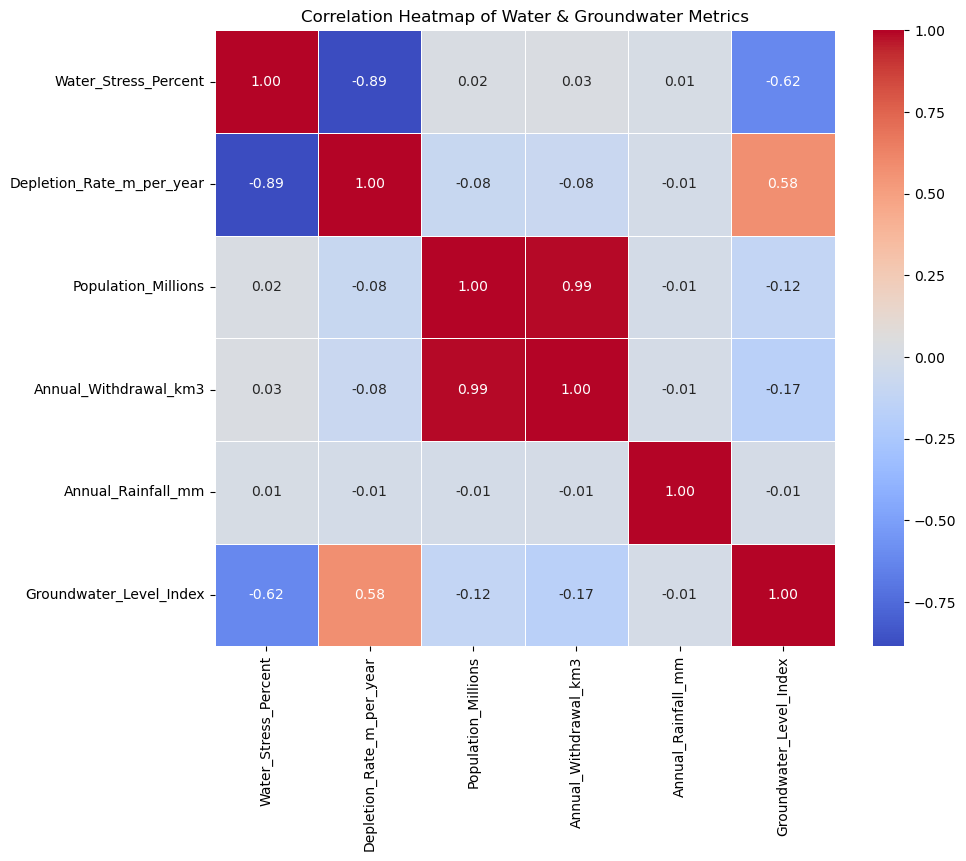

In [165]:
# Correlation heatmap for numeric columns
numeric_cols = ["Water_Stress_Percent", "Depletion_Rate_m_per_year", "Population_Millions", "Annual_Withdrawal_km3", "Annual_Rainfall_mm", "Groundwater_Level_Index"]

corr_df = df.select([col(c) for c in numeric_cols]).toPandas()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Water & Groundwater Metrics")
plt.show()


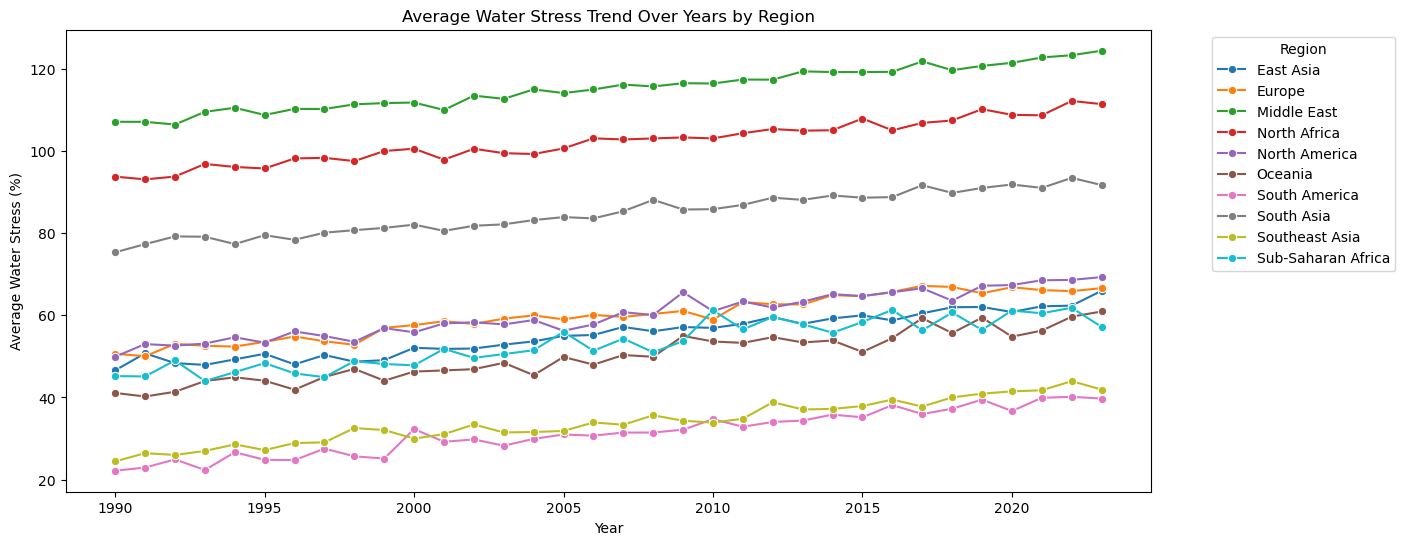

In [167]:
# Aggregate water stress by year and region
ws_trend_df = df.groupBy("Year", "Region").avg("Water_Stress_Percent").orderBy("Year", "Region")

ws_trend_pd = ws_trend_df.select(
    col("Year").alias("year"),
    col("Region").alias("region"),
    col("avg(Water_Stress_Percent)").alias("avg_water_stress")
).toPandas()

plt.figure(figsize=(14,6))
sns.lineplot(
    data=ws_trend_pd,
    x='year',
    y='avg_water_stress',
    hue='region',
    marker="o"
)
plt.title("Average Water Stress Trend Over Years by Region")
plt.xlabel("Year")
plt.ylabel("Average Water Stress (%)")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


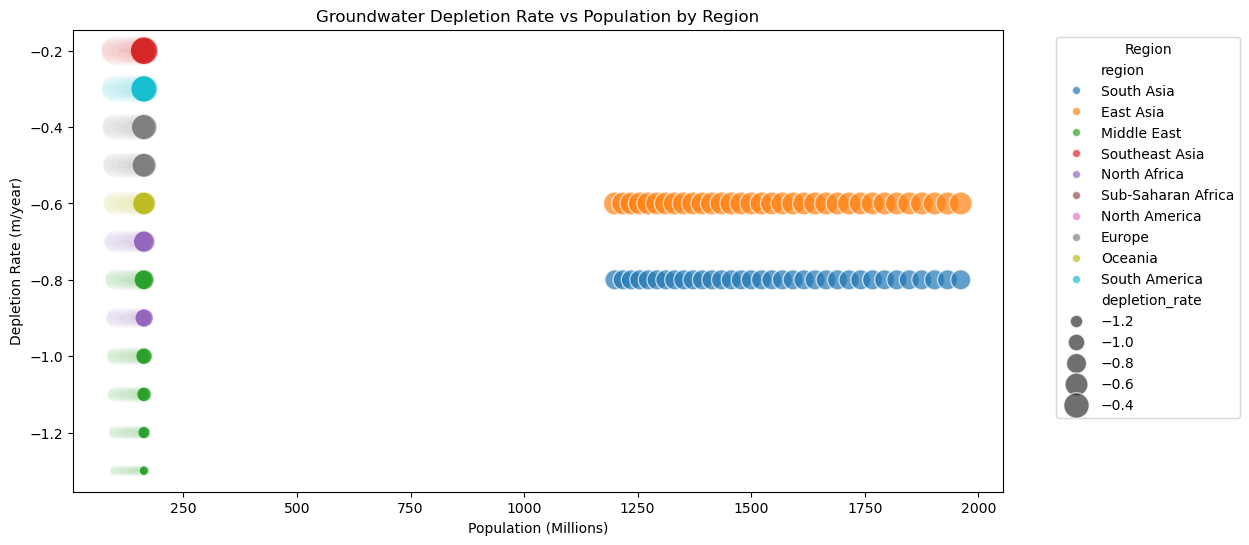

In [169]:
# Bubble plot: depletion rate vs population
pop_scatter_df = df.select(
    col("Country").alias("country"),
    col("Region").alias("region"),
    col("Population_Millions").alias("population"),
    col("Depletion_Rate_m_per_year").alias("depletion_rate")
)

pop_scatter_pd = pop_scatter_df.toPandas()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=pop_scatter_pd,
    x='population',
    y='depletion_rate',
    hue='region',
    size='depletion_rate',
    sizes=(50, 400),
    alpha=0.7
)
plt.title("Groundwater Depletion Rate vs Population by Region")
plt.xlabel("Population (Millions)")
plt.ylabel("Depletion Rate (m/year)")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


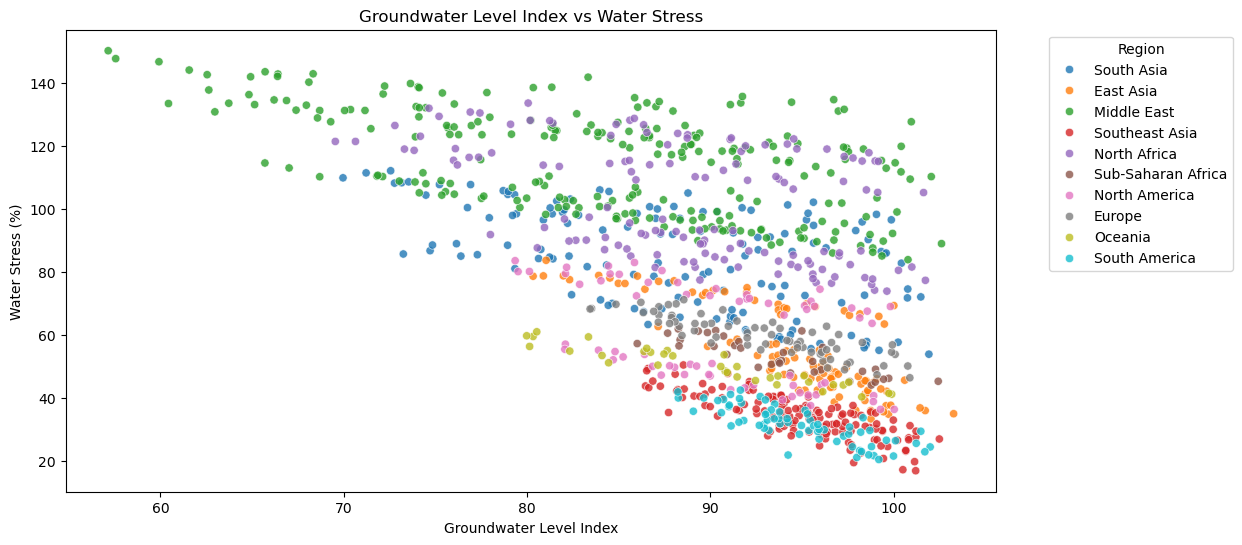

In [171]:
# Scatterplot: Groundwater Level Index vs Water Stress
gwl_df = df.select(
    col("Country").alias("country"),
    col("Region").alias("region"),
    col("Groundwater_Level_Index").alias("gwl_index"),
    col("Water_Stress_Percent").alias("water_stress_percent")
)

gwl_pd = gwl_df.toPandas()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=gwl_pd,
    x='gwl_index',
    y='water_stress_percent',
    hue='region',
    alpha=0.8
)
plt.title("Groundwater Level Index vs Water Stress")
plt.xlabel("Groundwater Level Index")
plt.ylabel("Water Stress (%)")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


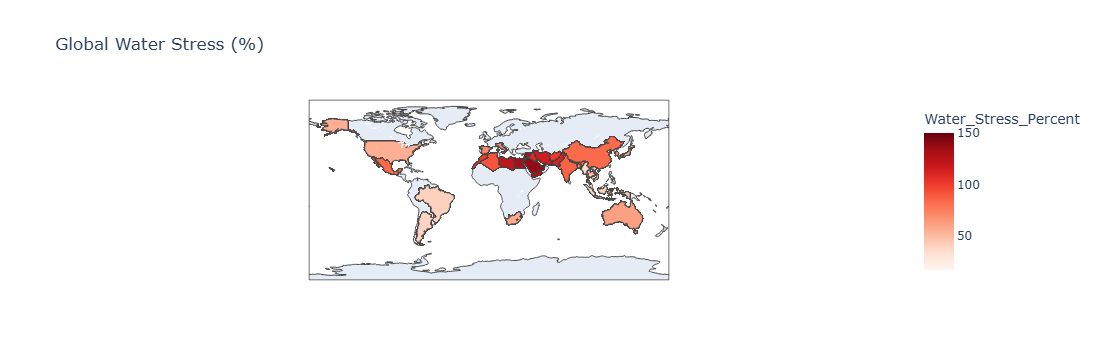

In [217]:
import plotly.express as px

# Convert PySpark DataFrame to Pandas
df_pd = df.select("Country", "Water_Stress_Percent", "Depletion_Rate_m_per_year").toPandas()

fig = px.choropleth(
    df_pd,
    locations="Country",
    locationmode="country names",
    color="Water_Stress_Percent",
    hover_name="Country",
    color_continuous_scale="Reds",
    title="Global Water Stress (%)"
)

fig.show()


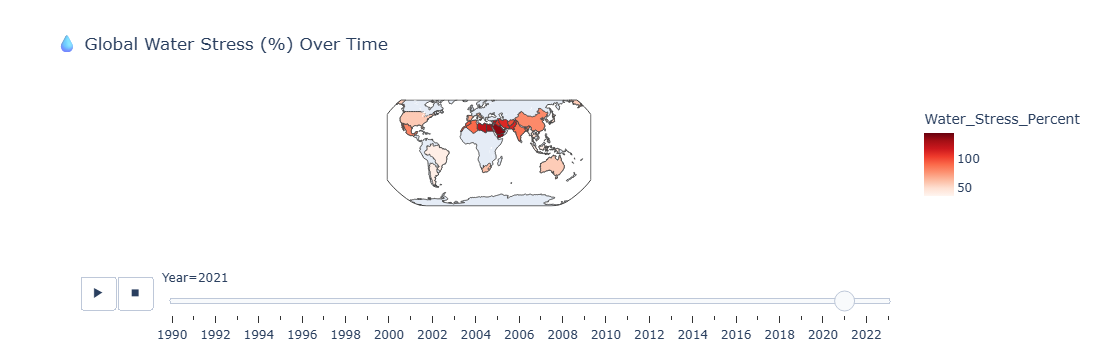

In [187]:
import plotly.express as px
# Assuming SparkSession and DataFrame 'df' are ready

# --- 1. PySpark Data Preparation (Select Columns + Year for the Slider) ---
# We must include the 'Year' column to enable the slider animation.
df_pd = df.select("Country", "Water_Stress_Percent", "Depletion_Rate_m_per_year", "Year").toPandas()

# --- 2. Create the Animated Choropleth Map with a Slider ---
# 'animation_frame="Year"' creates the slider (the "long sidebar")
# that allows users to move through the data by year.

fig = px.choropleth(
    df_pd,
    locations="Country",
    locationmode="country names",
    color="Water_Stress_Percent",
    hover_name="Country",
    # Use a visually appealing, long color scale
    color_continuous_scale=px.colors.sequential.Reds, 
    title="💧 Global Water Stress (%) Over Time",
    
    # *** KEY CHANGE FOR THE SLIDER/SIDEBAR ***
    # This creates the frame-by-frame animation slider
    animation_frame="Year", 
    
    # Optional: Customize the appearance of the slider control
    projection="natural earth" 
)

# Optional: Add animation controls for play/pause
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1500
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500

# --- 3. Display the interactive map ---
fig.show()

<Axes: xlabel='Country', ylabel='Total_Depletion'>

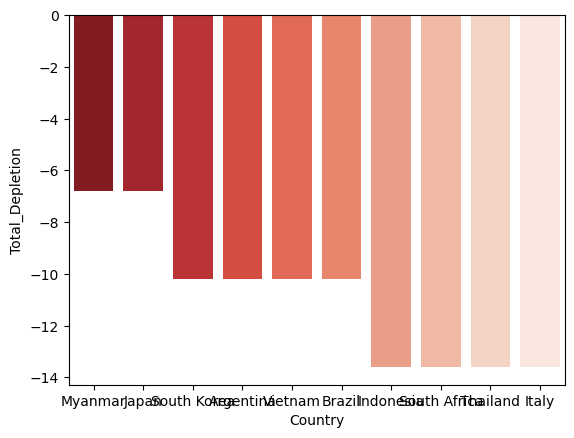

In [215]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.barplot(
    data=final_table_sorted,
    x="Country",
    y="Total_Depletion",
    palette="Reds_r",
    legend=False  # prevents the warning about palette without hue
)



In [195]:
import pandas as pd

# List to store results
stats_list = []

for col_name in numeric_cols:
    q1 = df.approxQuantile(col_name, [0.25], 0.01)[0]
    median = df.approxQuantile(col_name, [0.5], 0.01)[0]
    q3 = df.approxQuantile(col_name, [0.75], 0.01)[0]
    stats_list.append({
        "Column": col_name,
        "Q1": q1,
        "Median": median,
        "Q3": q3
    })

# Convert to pandas DataFrame for a nice table
stats_df = pd.DataFrame(stats_list)
stats_df


,Column,Q1,Median,Q3
0,Water_Stress_Percent,45.430,72.360,101.790
1,Depletion_Rate_m_per_year,-0.800,-0.600,-0.400
2,Population_Millions,114.340,130.730,147.270
3,Annual_Withdrawal_km3,12.977,16.603,20.471
4,Annual_Rainfall_mm,709.700,805.200,897.700
5,Groundwater_Level_Index,85.910,91.660,95.930


In [193]:
from pyspark.sql.functions import mean, max, col

df.groupBy("Region").agg(
    mean("Water_Stress_Percent").alias("Avg_Water_Stress"),
    mean("Depletion_Rate_m_per_year").alias("Avg_Depletion"),
    max("Depletion_Rate_m_per_year").alias("Max_Depletion")
).orderBy(col("Avg_Water_Stress").desc()).show()


+------------------+------------------+-------------------+-------------+
|            Region|  Avg_Water_Stress|      Avg_Depletion|Max_Depletion|
+------------------+------------------+-------------------+-------------+
|       Middle East|115.19109243697476|-0.9571428571428575|         -0.6|
|      North Africa|102.22845588235297| -0.674999999999999|         -0.5|
|        South Asia| 84.75794117647058|-0.7250000000000005|         -0.5|
|     North America| 60.11220588235292|-0.5500000000000007|         -0.5|
|            Europe| 59.75911764705882|-0.4499999999999993|         -0.4|
|         East Asia| 55.26588235294117|-0.3666666666666661|         -0.2|
|Sub-Saharan Africa|53.186470588235295|-0.4000000000000002|         -0.4|
|           Oceania|50.028823529411774|-0.6000000000000002|         -0.6|
|    Southeast Asia| 34.00102941176471|-0.3250000000000002|         -0.2|
|     South America| 31.39926470588235|-0.3000000000000004|         -0.3|
+------------------+------------------

In [197]:
from pyspark.sql import functions as F

# Step 1: Top 10 countries by average depletion rate
top10_countries = df.groupBy("Country").agg(
    F.mean("Depletion_Rate_m_per_year").alias("Avg_Depletion")
).orderBy(F.col("Avg_Depletion").desc()).limit(10)

top10_list = [row["Country"] for row in top10_countries.collect()]

# Step 2: Filter df for these top 10 countries
df_top10 = df.filter(F.col("Country").isin(top10_list))

# Step 3: Aggregate depletion per year for each country
df_top10_yearly = df_top10.groupBy("Country", "Year").agg(
    F.mean("Depletion_Rate_m_per_year").alias("Yearly_Depletion")
).orderBy("Country", "Year")

# Step 4: Pivot to have years as columns (optional, for a wide table)
years = [row["Year"] for row in df_top10.select("Year").distinct().orderBy("Year").collect()]

df_pivot = df_top10_yearly.groupBy("Country").pivot("Year", years).agg(F.first("Yearly_Depletion"))

# Step 5: Add total depletion over all years
df_total = df_top10_yearly.groupBy("Country").agg(F.sum("Yearly_Depletion").alias("Total_Depletion"))

# Join total depletion to pivot table
df_final = df_pivot.join(df_total, on="Country").orderBy(F.col("Total_Depletion").desc())

# Convert to pandas for display
final_table = df_final.toPandas()

final_table


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total_Depletion
0,Myanmar,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,...,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-6.8
1,Japan,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,...,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-6.8
2,South Korea,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,...,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-10.2
3,Argentina,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,...,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-10.2
4,Vietnam,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,...,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-10.2
5,Brazil,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,...,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-10.2
6,Indonesia,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-13.6
7,South Africa,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-13.6
8,Thailand,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-13.6
9,Italy,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-13.6
